Data includes airline reviews from 2006 to 2019 for popular airlines around the world with
multiple choice and free text questions. Data is scraped in Spring 2019. The main objective
is to predict whether passengers will refer the airline to their friends.

Feature descriptions briefly as follows:
airline: Name of the airline.

overall: Overall point is given to the trip between 1 to 10.
author: Author of the trip

reviewdate: Date of the Review customer

review: Review of the customers in free text format

aircraft: Type of the aircraft

travellertype: Type of traveler (e.g. business, leisure)

cabin: Cabin at the flight 

date flown: Flight date

seatcomfort: Rated between 1-5

cabin service: Rated between 1-5

foodbev: Rated between 1-5 

entertainment: Rated between 1-5

groundservice: Rated between 1-5

valueformoney: Rated between 1-5

recommended: Binary, target variable.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


import re
import nltk
import gensim
import gensim.downloader as gensim_api
import spacy

from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer


from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, precision_score,\
recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


from sklearn.metrics import classification_report,  plot_confusion_matrix
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE


In [7]:
sns.set_style('darkgrid')

In [8]:
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

In [9]:
data = pd.read_excel('/content/drive/MyDrive/data_airline_reviews.xlsx')
data.head()

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
target_variable = 'recommended'

In [11]:
# data[target_variable].values

In [12]:
data.shape

(131895, 17)

## **Feature Engineering**


*   Data Cleaning - Missing values partially
*   Dropping unproductive features
*   Converting feature types
*   Clustering




In [13]:
# Each row is alternated by a row of NaNs 
# So the dataset is 2 X the information

df = data.copy()
df.shape

(131895, 17)

In [14]:
# Dropping all those samples which are NaN
# Removing duplicates

df = df.dropna(axis = 0, how = 'all')
df.reset_index(drop = True, inplace = True)
print(df.shape)
df.head(3)

(65947, 17)


,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
1,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
2,Turkish Airlines,3.0,M Galerko,7th May 2019,âœ… Trip Verified | Rome to Prishtina via Ista...,NaN,Business,Economy Class,Rome to Prishtina via Istanbul,2019-05-01 00:00:00,1.0,4.0,1.0,3.0,1.0,2.0,no


airline                0
customer_review        0
author                 0
review_date            0
recommended         1507
overall             1930
value_for_money     1972
cabin               2644
cabin_service       5232
seat_comfort        5266
food_bev           13339
entertainment      21754
traveller_type     26192
route              26221
date_flown         26314
ground_service     26589
aircraft           46229
dtype: int64


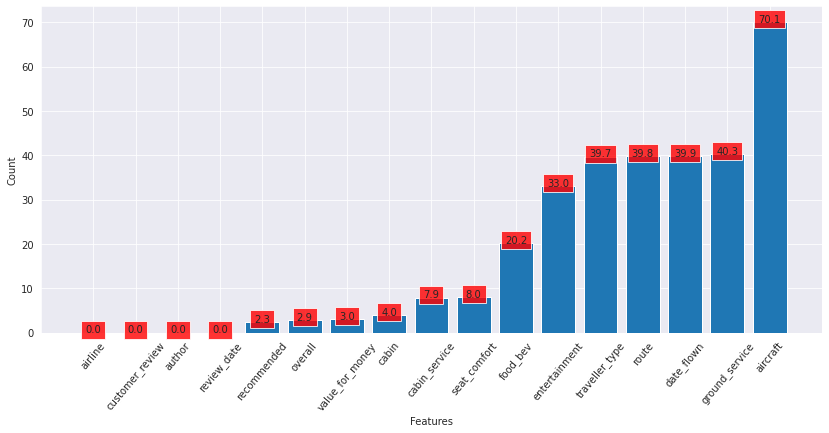

In [15]:
# Quite a few missing values
# Imputation will be required for many features
# Several are missing more than 30 % 
# Plot the missing values

print(df.isnull().sum().sort_values())

plt.figure(figsize = (14,6))
labels = df.isna().sum().sort_values().index
values = round(df.isna().sum().sort_values()/df.shape[0] * 100, 1)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
                 Bbox = dict(facecolor = 'red', alpha =.8))
        

plt.bar(labels, values) 
plt.xticks(labels, rotation = 50)
plt.yticks(np.arange(0,100, step = 10))

addlabels(labels, values)

plt.margins(0.05)
plt.ylabel('Count')
plt.xlabel('Features')
plt.show()

In [16]:
# Missing cells
# Total value - 18 % 

missing_values_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

print("Percentage missing : {:.3%} ".format(total_missing/total_cells))

del(missing_values_count)
del(total_cells)
del(total_missing)

Percentage missing : 18.302% 


In [17]:
# Dropping those rows where target_variable is NaN 
# Cant have missing values in the target_variable

df = df.dropna(axis =0, subset = ['recommended'])
df.shape

(64440, 17)

In [18]:
for x in df.columns:
  print ('{} :  {} % '.format(x , round(df[x].isnull().sum() / df.shape[0] * 100 , 1)))

airline :  0.0 % 
overall :  3.0 % 
author :  0.0 % 
review_date :  0.0 % 
customer_review :  0.0 % 
aircraft :  69.4 % 
traveller_type :  38.3 % 
cabin :  1.8 % 
route :  38.4 % 
date_flown :  38.5 % 
seat_comfort :  5.8 % 
cabin_service :  5.8 % 
food_bev :  18.4 % 
entertainment :  31.4 % 
ground_service :  38.9 % 
value_for_money :  0.7 % 
recommended :  0.0 % 


In [19]:
# Candidates for removing missing values
# Threshold - 35 %

drop_columns_na = []
for x in df.columns:
  if df[x].isnull().sum() / df.shape[0] * 100 >= 35:
    drop_columns_na.append(x)

drop_columns_na


df = df.drop(drop_columns_na, axis = 1)
df.shape
del(drop_columns_na)  

In [20]:
df.columns

Index(['airline', 'overall', 'author', 'review_date', 'customer_review',
       'cabin', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'value_for_money', 'recommended'],
      dtype='object')

In [21]:
df.shape

(64440, 12)

In [22]:
# NaN is a unique value BUT
# No value_counts() associated with it 

# To find all these samples when df['overall'] is a null value


df.loc[df['overall'][df['overall'].isnull()].index, :][:4]



,airline,overall,author,review_date,customer_review,cabin,seat_comfort,cabin_service,food_bev,entertainment,value_for_money,recommended
1369,Turkish Airlines,NaN,Mark Evans,8th January 2014,London Heathrow to Odessa (Ukraine) return. Th...,Economy Class,4.0,1.0,1.0,3.0,3.0,no
1373,Turkish Airlines,NaN,Sabeen Obaidullah,8th January 2014,I took a business class flight from London to ...,Business Class,1.0,3.0,3.0,2.0,1.0,no
1374,Turkish Airlines,NaN,Mark Evans,8th January 2014,London Heathrow to Odessa (Ukraine) return. Th...,Economy Class,4.0,1.0,1.0,3.0,3.0,no
1378,Turkish Airlines,NaN,T Malik,4th January 2014,TK0710 and TK0711. The service from Istanbul t...,Economy Class,2.0,1.0,4.0,1.0,2.0,no


In [23]:
# Seeing remaining missing values

df.isnull().sum()

airline                0
overall             1910
author                 0
review_date            0
customer_review        0
cabin               1138
seat_comfort        3759
cabin_service       3725
food_bev           11832
entertainment      20247
value_for_money      465
recommended            0
dtype: int64

In [24]:
# To find the categorical features and numerical features
# Easy to visualize and then work with then

numerical_features = df.describe().columns.tolist()
categorical_features = df.describe(include = 'object').columns.tolist()
categorical_features.remove(target_variable)

print(numerical_features)
print(categorical_features)


['overall', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'value_for_money']
['airline', 'author', 'review_date', 'customer_review', 'cabin']


In [25]:
# Examine cardinality of categorical features
# Some are obviously unique values
# Others cardinality may need to be reduced

for x in categorical_features:
  print ('{} : {}'.format(x, df[x].nunique()))

airline : 81
author : 43289
review_date : 3010
customer_review : 59750
cabin : 4


In [26]:
# These features are discrete features
# EDA can be done in a pseudo categorical sense
# They are discrete numerical
# There is an ordinal sense to each feature
# As they are numered 1-5

for x in numerical_features:
  print ('{} : {}'.format(x, df[x].nunique()))

overall : 10
seat_comfort : 5
cabin_service : 5
food_bev : 5
entertainment : 5
value_for_money : 5


In [27]:
# All should be int data type
# No need to remain as float data type

df.loc[: ,numerical_features][:5]

,overall,seat_comfort,cabin_service,food_bev,entertainment,value_for_money
0,7.0,4.0,5.0,4.0,4.0,4.0
1,2.0,4.0,1.0,1.0,1.0,1.0
2,3.0,1.0,4.0,1.0,3.0,2.0
3,10.0,4.0,5.0,5.0,5.0,5.0
4,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
# Converting float to int type data
# Most numerical columns

df[numerical_features] = df[numerical_features].astype(dtype = 'Int64', errors = 'ignore')
df.dtypes

airline            object
overall             Int64
author             object
review_date        object
customer_review    object
cabin              object
seat_comfort        Int64
cabin_service       Int64
food_bev            Int64
entertainment       Int64
value_for_money     Int64
recommended        object
dtype: object

In [29]:
# No need for features - author
# Too many 

df_reviews = pd.DataFrame({'author' : df['author'].copy(),
                           'review' : df['customer_review'].copy()}
                          )

# df_reviews.head(20)

drop_candidates = []
drop_candidates.extend(['author'])
df.shape

(64440, 12)

In [30]:
drop_candidates

['author']

In [31]:
# Best to cluster the airlines into n different clusters
# Otherwise its a high cardinality feature
# Theres no way to cateorize them solely based on intuition 
# For now its best to drop the feature
# Clustering done by K Means after dealing with missing values

# Another option is to use target encoding for airline
# As it is a categorical feature

# drop_candidates.append('airline')

In [32]:
df.head(3)

,airline,overall,author,review_date,customer_review,cabin,seat_comfort,cabin_service,food_bev,entertainment,value_for_money,recommended
0,Turkish Airlines,7,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,Economy Class,4,5,4,4,4,yes
1,Turkish Airlines,2,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,Economy Class,4,1,1,1,1,no
2,Turkish Airlines,3,M Galerko,7th May 2019,âœ… Trip Verified | Rome to Prishtina via Ista...,Economy Class,1,4,1,3,2,no


In [33]:
df = df.drop(drop_candidates, axis = 1)
print(df.shape)
df.head(4)
del(drop_candidates)

(64440, 11)


In [34]:
# Review date is also high cardinality
# But it can be useful
# Later to apply feature engineering

df['review_date'].nunique()

3010

In [35]:
df['review_date'].sample(10)

24729        29th July 2014
63600        7th March 2018
18548         31st May 2015
36563     3rd February 2017
51265       18th March 2019
22544      9th January 2018
51006       5th August 2015
41636     28th October 2014
9803        19th April 2015
17338    30th December 2017
Name: review_date, dtype: object

In [36]:
# date_flown can be dropped because of
# review_date is a better approximation
# assumption - review date is nearly same as flight date
# Hypothesis Testing here: 
# H0 - review date ~ flight date 
# HA - review date != flight date


print(df.isnull().sum())

airline                0
overall             1910
review_date            0
customer_review        0
cabin               1138
seat_comfort        3759
cabin_service       3725
food_bev           11832
entertainment      20247
value_for_money      465
recommended            0
dtype: int64


In [37]:
df['review_date'] = pd.to_datetime(df['review_date'])

In [38]:
df.head(4)

,airline,overall,review_date,customer_review,cabin,seat_comfort,cabin_service,food_bev,entertainment,value_for_money,recommended
0,Turkish Airlines,7,2019-05-08,âœ… Trip Verified | London to Izmir via Istanb...,Economy Class,4,5,4,4,4,yes
1,Turkish Airlines,2,2019-05-07,âœ… Trip Verified | Istanbul to Bucharest. We ...,Economy Class,4,1,1,1,1,no
2,Turkish Airlines,3,2019-05-07,âœ… Trip Verified | Rome to Prishtina via Ista...,Economy Class,1,4,1,3,2,no
3,Turkish Airlines,10,2019-05-06,âœ… Trip Verified | Flew on Turkish Airlines I...,Economy Class,4,5,5,5,5,yes


In [39]:
df.insert(loc =df.columns.get_loc('review_date')+1,
          column = 'review_review_date',
          value = df['review_date'].dt.day_of_week,
          )


df.insert(loc =df.columns.get_loc('review_date')+2,
          column = 'review_month',
          value = df['review_date'].dt.month,
          )


df.insert(loc =df.columns.get_loc('review_date')+3,
          column = 'review_year',
          value = df['review_date'].dt.year,
          )


df = df.drop('review_date', axis = 1)

df.rename(columns = {'review_review_date' : 'review_date'}, inplace = True)

In [40]:
df.head(3)

,airline,overall,review_date,review_month,review_year,customer_review,cabin,seat_comfort,cabin_service,food_bev,entertainment,value_for_money,recommended
0,Turkish Airlines,7,2,5,2019,âœ… Trip Verified | London to Izmir via Istanb...,Economy Class,4,5,4,4,4,yes
1,Turkish Airlines,2,1,5,2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,Economy Class,4,1,1,1,1,no
2,Turkish Airlines,3,1,5,2019,âœ… Trip Verified | Rome to Prishtina via Ista...,Economy Class,1,4,1,3,2,no


In [41]:
# Well balanced so no target_variable resampling

df['recommended'].value_counts()

no     33894
yes    30546
Name: recommended, dtype: int64

In [42]:
# day is being converted to categorical feature
# recommended yes - 1 ; no - 0
# Two values - weekday / weekend
# Intuition says it could be an important feature


df['review_date'] = df['review_date'].apply(lambda x : 'Weekday' if x < 5 else 'Weekend')
df['recommended'] = df['recommended'].apply(lambda x : 1 if x == 'yes' else 0)

In [43]:
df['review_date'].value_counts()

Weekday    49425
Weekend    15015
Name: review_date, dtype: int64

In [44]:
for x,y  in enumerate(df.columns):
  print (x, y)

0 airline
1 overall
2 review_date
3 review_month
4 review_year
5 customer_review
6 cabin
7 seat_comfort
8 cabin_service
9 food_bev
10 entertainment
11 value_for_money
12 recommended


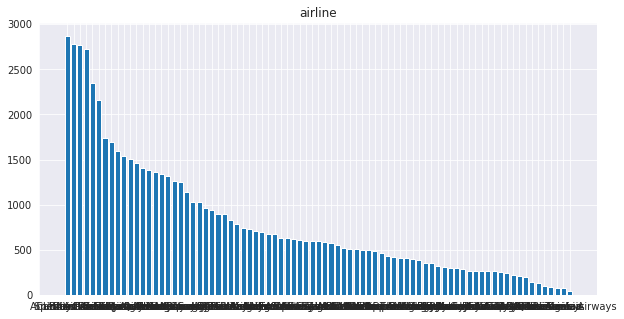

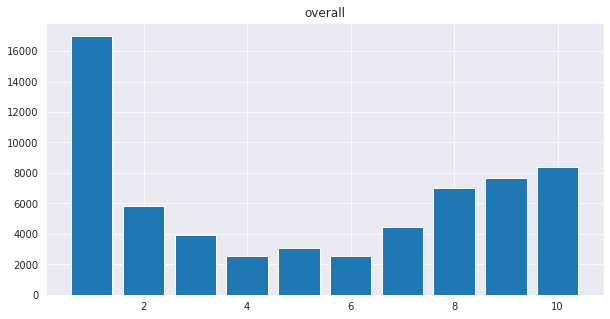

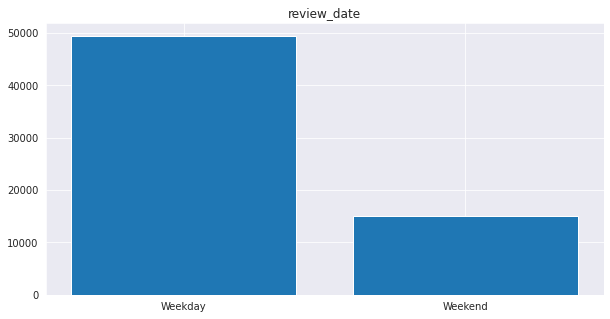

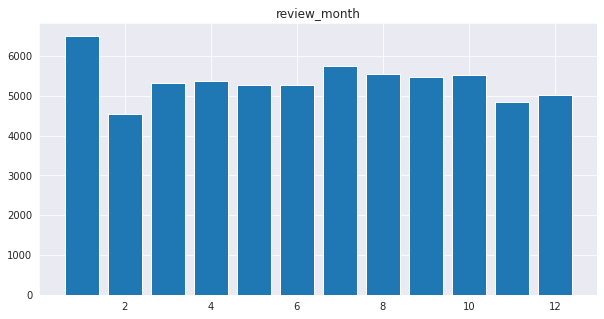

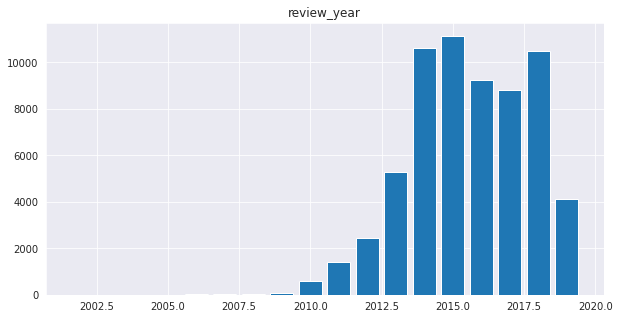

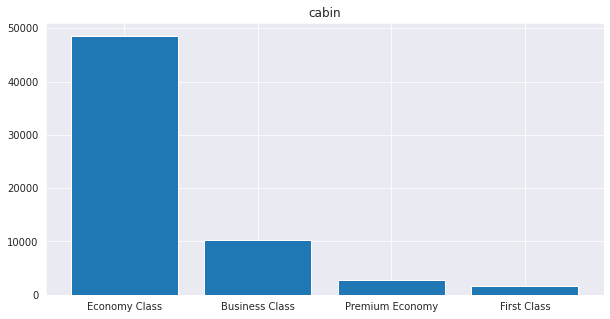

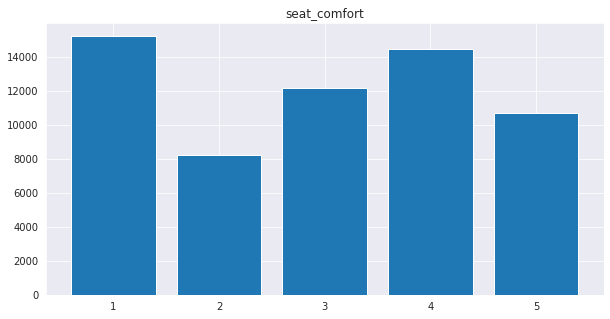

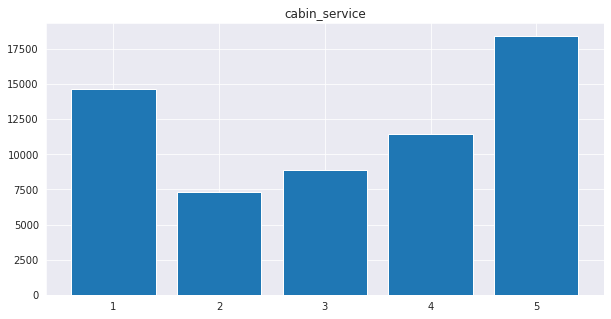

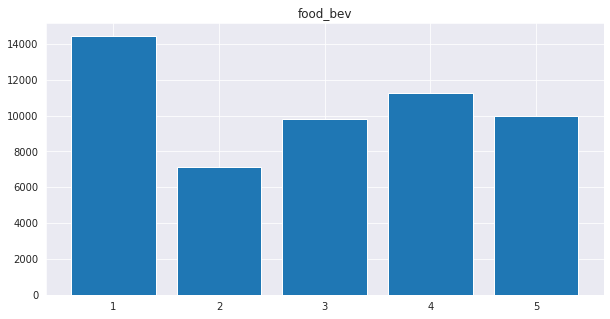

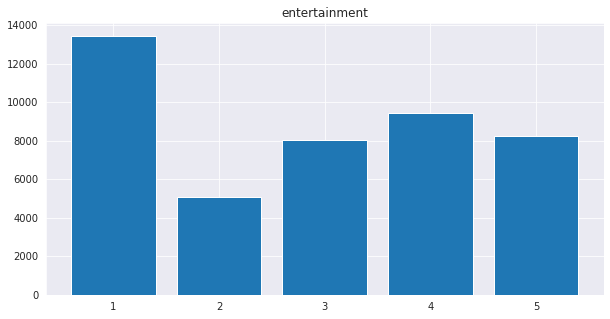

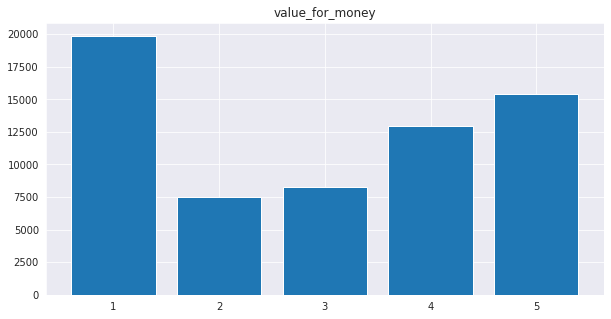

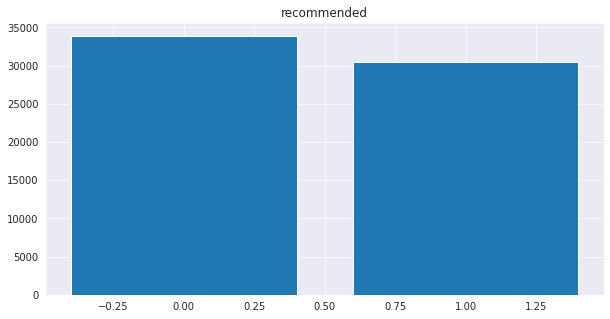

In [45]:
# To explore the sparsity
# No feature seems to have sparse value
# Enough samples such that no feature engineering required


for x,y in enumerate(df.columns):

  if y not in ('customer_review'):
    labels = df[y].value_counts().index
    values = df[y].value_counts().values
    plt.figure(figsize = (10,5))  
    plt.bar(labels, values)
    plt.title(y)
    plt.show()  

Amenities like {food_bev, cabin service, entertainment} dont follow normal distribution as they are not natural phenomenon

In [46]:
# Take categorical features and numerical features into variables
# Many features dropped and some changed as well

numerical_features = df.describe().columns.tolist()
categorical_features = df.describe(include = 'object').columns.tolist()
numerical_features.remove(target_variable)

print(numerical_features)
print(categorical_features)

['overall', 'review_month', 'review_year', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'value_for_money']
['airline', 'review_date', 'customer_review', 'cabin']


### **Text data - feature engineering**

In [47]:
df.head()

,airline,overall,review_date,review_month,review_year,customer_review,cabin,seat_comfort,cabin_service,food_bev,entertainment,value_for_money,recommended
0,Turkish Airlines,7,Weekday,5,2019,âœ… Trip Verified | London to Izmir via Istanb...,Economy Class,4,5,4,4,4,1
1,Turkish Airlines,2,Weekday,5,2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,Economy Class,4,1,1,1,1,0
2,Turkish Airlines,3,Weekday,5,2019,âœ… Trip Verified | Rome to Prishtina via Ista...,Economy Class,1,4,1,3,2,0
3,Turkish Airlines,10,Weekday,5,2019,âœ… Trip Verified | Flew on Turkish Airlines I...,Economy Class,4,5,5,5,5,1
4,Turkish Airlines,1,Weekday,5,2019,âœ… Trip Verified | Mumbai to Dublin via Istan...,Economy Class,1,1,1,1,1,0


In [48]:
df['customer_review'][0]

'âœ… Trip Verified | London to Izmir via Istanbul. First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and pl

In [49]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [50]:
import re
import nltk
import spacy

from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=True, flg_lemm=False, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    #tk = WordTokenizer()
    lst_text = word_tokenize(text)

    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
sw = stopwords.words('english')

df["review"] = df["customer_review"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords= sw))
# df.drop(['customer_review'], axis = 1, inplace = True)

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
df['review'][0]

In [ ]:
# Vectorizer
# Use TF IDF

vectorizer = TfidfVectorizer(max_df = 0.9, min_df = 10, max_features = 5000)
X = vectorizer.fit_transform(df['review'])


In [ ]:
X.toarray()

In [ ]:
X.toarray()[4560]

In [ ]:
vectorizer.get_feature_names()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
# with_mean = False for sparse matrix

scaler = StandardScaler(with_mean = False)
X_scaled = scaler.fit_transform(X)

'''
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(X_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

'''

In [ ]:
# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=7, random_state=42)
# fit the model
kmeans.fit(X_scaled)
# store cluster labels in a variable
clusters = kmeans.labels_

In [ ]:
df.head()

In [ ]:
df.insert(len(df.columns), "review_cluster", clusters.tolist(),True)
df.head(3)

In [ ]:
df["sentiment"] = df['review'].apply(lambda x: 
                   TextBlob(x).sentiment.polarity)

df.head(3)

In [ ]:
drop_candidates = ['review']
df.drop(drop_candidates, axis = 1, inplace = True)

del(drop_candidates)
df.head()

In [ ]:
df['review_cluster'].value_counts()

Review clusters is a poorly done clustering \\
Some clusters have very few samples \\
Another approach is necessary

In [ ]:
df = df.drop(['review_cluster'], axis = 1)
df.head(3)

## **Data Visualisation**

### **Exploration - Numerical (Pseudo-cat)**

Visualize the categorical features :

['overall',
 'review_month',
 'review_year',
 'seat_comfort',
 'cabin_service',
 'food_bev',
 'entertainment',
 'value_for_money']

In [ ]:
numerical_features

In [ ]:
def get_labels_values(feature):

# Gives the percentage of feature_variable matching target_variable = [0,1]
# Then you can find out distributions for each target_variable
# There are missing values
# But visualization is perhaps better to perform before the  

  feature_values = []
  list_un = []
  for x in sorted(df[target_variable].unique()):
    list_un = []

    for y in sorted(feature.value_counts().sort_index().index.tolist()):
      list_un.append(df.loc[(df[target_variable]==x) & (feature==y)].shape[0])
    
    # At the end of the loop this appends
    else :
      feature_values.append(tuple(list_un))

  labels = sorted(feature.value_counts().sort_index().index.tolist())
  
  return labels, feature_values



In [ ]:
def plot_labels_target(feature):

# Creates the plot for each feature of dataset


  plt.figure(figsize = (12,3))
  plt.title(str(feature))
  df[feature].value_counts().sort_index().plot.bar()
  plt.show()
  labels,y = get_labels_values(df[feature])

  plt.figure(figsize = (12,3))
  for x in range(1, len(y)+ 1): 
    
    plt.subplot(1,2,x)
    plt.title(str(x-1))
    plt.bar(labels, y[x -1])

  plt.figure(figsize = (12,3))
 
  list_un = []
  
  for x in range(len(y[0])):
    list_un.append(y[1][x]/ (y[0][x] + y[1][x]))   

  plt.bar(labels,list_un )
  plt.title('Recommend %')
  plt.show() 
  

  


In [ ]:
# Information rich feature
# Categories are reasonably distributed
# Showing a clear pattern from 0 to 1


plot_labels_target('overall')

In [ ]:
# Information rich feature
# Many categories have few number of samples
# Showing a clear pattern from lower to higher

plot_labels_target('seat_comfort')

In [ ]:
# Information rich feature
# Categories are reasonably distributed
# Showing a clear pattern from lower to higher

plot_labels_target('cabin_service')

In [ ]:
# Information rich feature
# Categories are reasonably distributed
# Showing a clear pattern from lower to higher

plot_labels_target('food_bev')

In [ ]:
# Information rich feature
# Category 2 has fewer samples otherwise reasonably distributed
# Showing a clear pattern from lower to higher

plot_labels_target('entertainment')

In [ ]:
# Information rich feature
# Categories are reasonably distributed
# Showing a clear pattern from lower to higher

plot_labels_target('value_for_money')

In [ ]:
# It has some predictive power
# Seems like airline travel is getting worse every year 

plot_labels_target('review_year')

In [ ]:
# Plots are identical
# Very little information from this

plot_labels_target('review_date')

### **Exploration - Categorical**
Visualize the categorical features 

[review_date, cabin]


In [ ]:
categorical_features

In [ ]:
# Not much information from this feature
# Some categories are sparse

plot_labels_target('cabin')

In [ ]:
# review_date has no predictive power for target variable
# As expected 


plot_labels_target('review_date')

## **Feature Engineering - Missing Values (Previously only the sparse features dropped)**

In [ ]:
df.head(5)
       

In [ ]:
# Showing the number of missing values

plt.figure(figsize = (14,6))
labels = df.isna().sum().sort_values().index
values = round(df.isna().sum().sort_values()/df.shape[0] * 100, 1)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
                 Bbox = dict(facecolor = 'red', alpha =.8))
        
plt.bar(labels, values) 
plt.xticks(labels, rotation = 50)
plt.yticks(np.arange(0,100, step = 10))

addlabels(labels, values)

plt.margins(0.05)
plt.title('Missing Value %')
plt.ylabel('Missing % ')
plt.xlabel('Features')
plt.show()

In [ ]:
df.isnull().sum()

In [ ]:
df[numerical_features][:8]

In [ ]:
# Use advanced imputation techniques for this one 
# Using knn imputer

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)
df[numerical_features] = imputer.fit_transform(df[numerical_features])

df['cabin'] = df['cabin'].fillna(method='bfill', axis=0).fillna(df['cabin'].value_counts().index[0])

## **Feature Engineering - Clustering (All samples)**





In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score



In [ ]:
df.head(4)

,airline,overall,review_date,review_month,review_year,cabin,seat_comfort,cabin_service,food_bev,entertainment,value_for_money,recommended
0,Turkish Airlines,7.0,Weekday,5.0,2019.0,Economy Class,4.0,5.0,4.0,4.0,4.0,1
1,Turkish Airlines,2.0,Weekday,5.0,2019.0,Economy Class,4.0,1.0,1.0,1.0,1.0,0
2,Turkish Airlines,3.0,Weekday,5.0,2019.0,Economy Class,1.0,4.0,1.0,3.0,2.0,0
3,Turkish Airlines,10.0,Weekday,5.0,2019.0,Economy Class,4.0,5.0,5.0,5.0,5.0,1


Text(0, 0.5, 'Inertia')

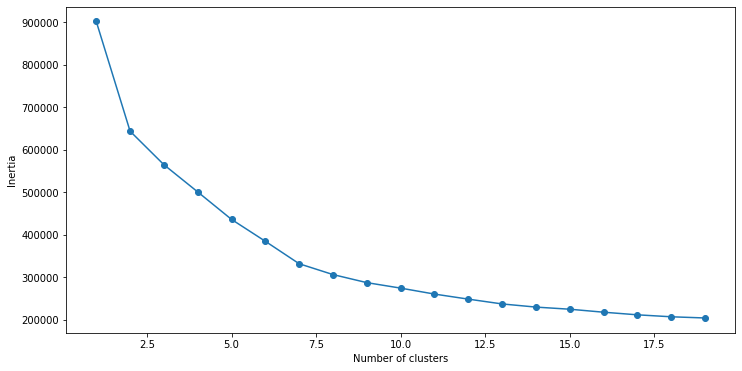

In [ ]:
'''
X =df.copy()
X.pop('recommended')
X.pop('airline')

X = pd.get_dummies(X, columns=["review_date", "cabin"], prefix=["review_date","cabin"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(X_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

'''

In [ ]:
data.head()

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Model + Feature Encoding - Random Forest**

In [ ]:
target_variable

'recommended'

In [ ]:
df_copy = df.copy()

In [ ]:
# review_date, cabin have to be encoded
# Other are numeric (discrete numeric)


X = df_copy.copy()
y = df_copy[target_variable].copy()
X = X.drop(target_variable, axis = 1)
X.head(3)



,overall,review_date,review_month,review_year,cabin,seat_comfort,cabin_service,food_bev,entertainment,value_for_money
0,7.0,Weekday,5.0,2019.0,Economy Class,4.0,5.0,4.0,4.0,4.0
1,2.0,Weekday,5.0,2019.0,Economy Class,4.0,1.0,1.0,1.0,1.0
2,3.0,Weekday,5.0,2019.0,Economy Class,1.0,4.0,1.0,3.0,2.0


In [ ]:
X = pd.get_dummies(X, columns=["review_date", "cabin"], prefix=["review_date","cabin"])
X.head()

=== Confusion Matrix ===


<Figure size 432x288 with 0 Axes>

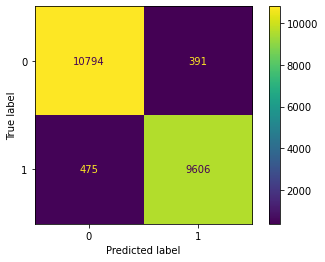

In [ ]:
# Using Random Forest 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

rf_classifier = RandomForestClassifier(n_estimators = 100, 
                                        max_leaf_nodes = None, max_features = None,
                                        max_depth = None, criterion = 'entropy')

rf_classifier.fit(X_train,y_train)
rf_predict = rf_classifier.predict(X_test)
# rfc_cv_score = cross_val_score(rf_classifier, X, y, cv=10, scoring='f1_micro')

print("=== Confusion Matrix ===")

plt.figure()
plot_confusion_matrix(rf_classifier, X_test, y_test)
plt.show()


In [ ]:
# Showing good performance on the dataset

round(f1_score(y_test, rf_predict) * 100, 2)

95.69

In [ ]:
# Showing good performance on the dataset

from sklearn.model_selection  import cross_val_score
cross_val_score(RandomForestClassifier(), X, y)

array([0.94956549, 0.95204842, 0.95204842, 0.96423029, 0.97136872])